In [87]:
%matplotlib inline
from scipy import io
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import io, signal # we will also import the signal module, from scipy
from PIL import Image

 ## Table Of Contents 
1. [Introduction and Background](#intro)
- [Research Question and Hypothesis](#hypothesis)
- [Data Description](#desc)
- [Data Pre-processing](#process)
- [Data Analysis](#analyze)
    1. [Time Series Analysis](#timeseries)
    2. [Power Spectral Density](#psd)
    3. [Time-Frequency Analysis](#timefreq)
    4. [Filtering](#timeseries) 
    5. [Instantaneous Power Signal](#instant)
    6. [Theta Phase Synchronization](#coupling)
- [Data Results](#results)
- [Conclusions and Discussions](#conclude)
- [Considerations and Limitations](#considerations)
- [References](#refer)

## Method
1. We will look at the time series for each brain region to view how the awake state  compares to the sleep state
2. We will find which frequencies contribute the most during the awake state and compare that to the sleep state
3. We will plot the frequencies across time to view how the frequencies change across time and which seems to contribute the most.
3. For each brain region, we will decompose the signal into all of the brainwave components (delta, beta, alpha, etc.) and compare the awake state and sleep state side by side.
4. For each brain region, we will compute the analytic signal (omitting the negative frequencies), extract the theta component and plot the instantaneous power of the theta component through time to analyze the theta frequency contribution through time and compare the sleep and awake state.
5. A lot of research has been done tying conscious states to the synchronization of brain waves across the brain regions so we will extract the theta component once again, compute the instantaneous phase, and plot the synchronization of the instantaneous phase across the brain regions to see if they synchronize well. We will then take the average of synchronization and compare the awake state to the sleep state to see if higher synchronization rate correlates with consciousness

<a id='intro'></a>
## Introduction

In recent years, there has been an increase in literature devoted to understanding the functional contributions of neural oscillations. Many of these studies investigate the relationship between brain regions and synchronous neural oscillations and their role in motor processes (Salenius, S., & Hari, R, 2003; MacKay, W. A., 1997).
It is suspected that synchronous neural oscillations that occur globally rather than locally give rise to conscious awareness (Ward, L.M., 2003).


<a id='hypothesis'></a>
## Research Question & Hypothesis

**Research Question:** How do oscillation frequencies compare during slow wave sleep and wakefulness across the brain regions? Is there an oscillatory basis for consciousness? 

**Hypothesis:**


<a id='desc'></a>

## Dataset

### Monkey Resting ECoG Data
Recorded from monkey whole cortex. ECoG sampled at 1000Hz, 3 channels. From **Yanagawa et al., PLOS ONE, 2013.**

In this experiment, the monkey is sitting in a chair with no task demands. 5 minutes of data each are provided during 3 different stages: awake eyes open, awake eyes closed, and anesthesized. They are stored in `ecog_awake`,`ecog_eyesclosed`, and `ecog_anes` respectively. The sampling rate is provided, from which you can compute the time vectors (they can have their own time vectors all starting from 0s).

`labels` contains information about which brain regions the 3 channels are located in, while `elec_num` has the electrode number, which you can find on the brain map image included in the same folder (brainmap.jpg).

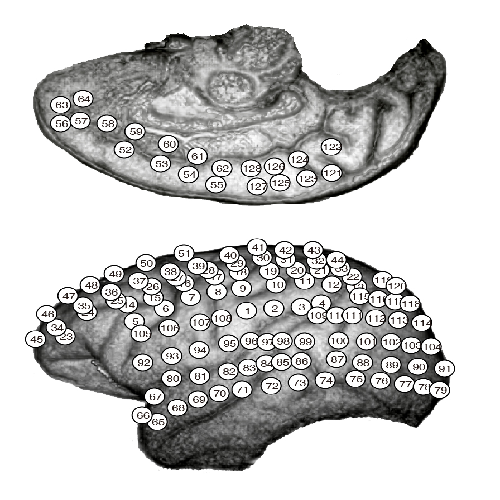

In [88]:
img = Image.open('ECoG_monkey/brainmap.jpg').resize((500,500))
img

<a id='process'></a>

## Data Pre-Processing

In [89]:
awake_cingulate = monkey_ecog_data['ecog_eyesopen'][0,:]
awake_occipital = monkey_ecog_data['ecog_eyesopen'][1,:]
awake_temporal = monkey_ecog_data['ecog_eyesopen'][2,:]


anes_cingulate =  monkey_ecog_data['ecog_anes'][0,:]
anes_occipital =  monkey_ecog_data['ecog_anes'][1,:]
anes_temporal =  monkey_ecog_data['ecog_anes'][2,:]

elec_num = monkey_ecog_data['elec_num']
fs = monkey_ecog_data['fs']
regions = monkey_ecog_data['labels']
states = ['Eyes Open','Anesthesia']
N = awake_cingulate.shape[0]
t_vector = np.arange(0, N/fs, 1/fs)
colors = ['midnightblue','darkmagenta','steelblue','c', 'mediumseagreen', 'darkorange']
dt = 1 / fs
T_exp = len(awake_cingulate) 

<a id='analyze'></a>

## Data Analysis

<a id='analyze'></a>

## 1. Time Series Analysis

In [90]:
def plot_time_series(data1, label1, data2, label2, title, data3=None, label3=None):
    plt.figure(figsize=(16,2))
    plt.plot(t_vector, data1, label=label1, c='darkmagenta')
    plt.plot(t_vector, data2, label=label2, c='steelblue')
    if data3 is not None:
        plt.plot(t_vector, data3, label=label3, c='yellowgreen')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (uV)')
    plt.xlim([0,5])
    plt.ylim([-2000, 2000])
    plt.title(title + " Time Series")

Here we plot a time series comparing the awake and anesthetized data for all brain regions. From a first glance, it appears that awake data has a higher frequency than anesthetized data. We were anticipating the anesthetized data to produce slow waves since anesthesia is "commonly used as a model of slow wave sleep, [...] ketamine-xylazine anesthesia reproduces the main features of sleep slow oscillation" and slow waves are often "associated with diminished consciousness even in the presence of high gamma activity" (Chauvette, S., Crochet, S., et. al., 2011; Murphy, M., Bruno, M. A., et. al., 2011). However, the monkeys in this study were injected with Medetomidine-Ketamine rather than XylazineKetamine. We will explore this further. 

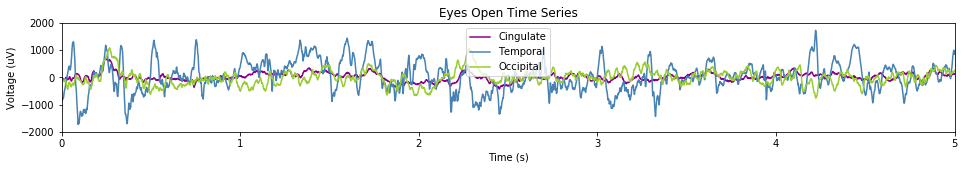

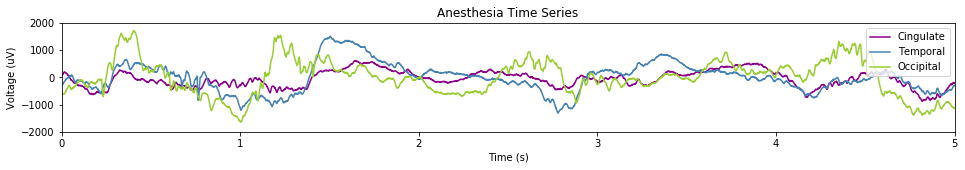

In [91]:
plot_time_series(awake_cingulate, 'Cingulate', awake_temporal, 'Temporal', 'Eyes Open', awake_occipital, 'Occipital')
plot_time_series(anes_cingulate, 'Cingulate', anes_temporal, 'Temporal', 'Anesthesia', anes_occipital, 'Occipital')

Since we are comparing the wake state to the anesthetized state, we've plotted each brain region and signal from the awake state compared tot he anesthesia state. Across all regions it appears consistent that the awake state often produces higher frequencies than the anesthetized state. 

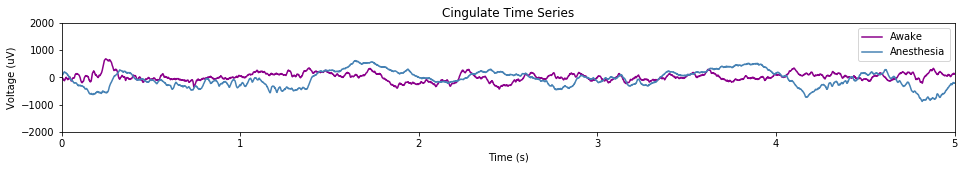

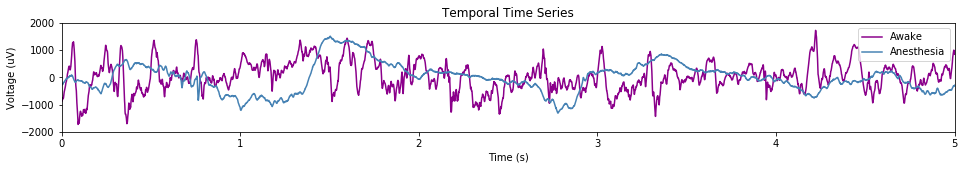

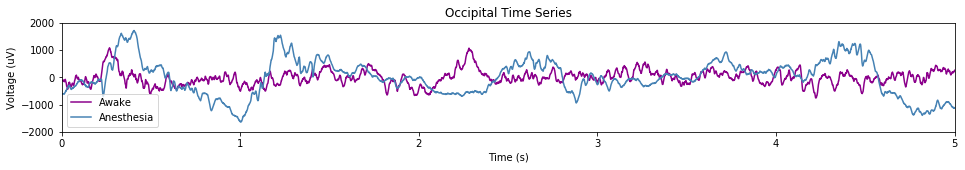

In [92]:
plot_time_series(awake_cingulate, 'Awake', anes_cingulate, 'Anesthesia', 'Cingulate')
plot_time_series(awake_temporal, 'Awake', anes_temporal, 'Anesthesia', 'Temporal')
plot_time_series(awake_occipital, 'Awake', anes_occipital, 'Anesthesia', 'Occipital')

<a id='psd'></a>

## 2. Fourier Transform & Power Spectral Density

Now, we will transform from time domain to frequency domain using the fourier transform. We will find which frequencies contribute the most during the awake state and compare that to the sleep state by plotting the power spectral density. 

### PSD State Comparisons (Eyes Closed, Eyes Open, Anesthesia)

In [93]:
brain_wave_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
bandpass_values = [[0.5,4], [4,8], [8,13], [13,32], [32,100]]

In [94]:
def return_PSD_data(data):
    f_sp, t_sp, psd = signal.spectrogram(data, fs, mode = 'psd')
    psd = np.array([i.mean() for i in psd])
    return f_sp, t_sp, psd

In [95]:
def plot_PSD_state(f_sp, open_psd, anes_psd):
    plt.plot(f_sp, open_psd,label = 'Eyes Open', color = colors[1])
    plt.plot(f_sp, anes_psd,label = 'Anesthesia', color = 'steelblue')
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.yscale("log")
    plt.xlim(-5,500)
    plt.legend()
    
def plot_PSD_region(f_sp, temp_psd, occ_psd, cing_psd):
    plt.plot(f_sp, temp_psd,  label = 'Temporal', color = colors[1])
    plt.plot(f_sp, occ_psd, label = 'Occipital', color = colors[3])
    plt.plot(f_sp, cing_psd, label = 'Cingulate', color = colors[4])
    plt.xlabel("Frequency")
    plt.ylabel("Power Spectral Density")
    plt.yscale("log")
    plt.xlim(-5,500)
    plt.legend()

In [96]:
open_temp_f_sp, open_temp_t_sp, open_temp_psd = return_PSD_data(awake_temporal)
anes_temp_f_sp, anes_temp_t_sp,  anes_temp_psd = return_PSD_data(anes_temporal)

open_occ_f_sp, open_occ_t_sp, open_occ_psd = return_PSD_data(awake_occipital)
anes_occ_f_sp, anes_occ_t_sp,  anes_occ_psd = return_PSD_data(anes_occipital)

open_cing_f_sp, open_cing_t_sp, open_cing_psd = return_PSD_data(awake_cingulate)
anes_cing_f_sp, anes_cing_t_sp, anes_cing_psd = return_PSD_data(anes_cingulate)

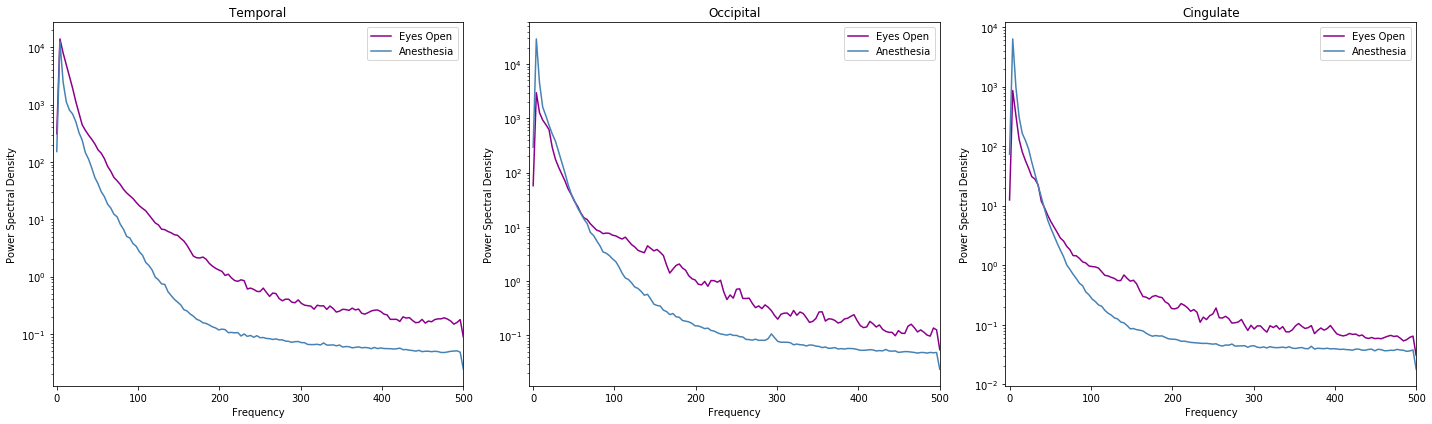

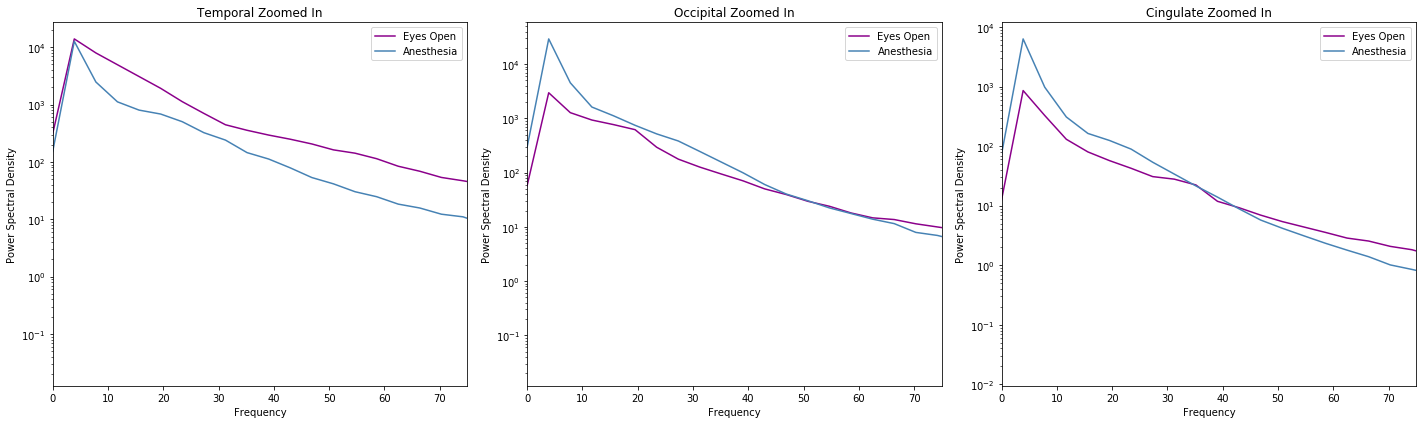

In [97]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title('Temporal')
plot_PSD_state(open_temp_f_sp, open_temp_psd, anes_temp_psd)

plt.subplot(1,3,2)
plt.title('Occipital')
plot_PSD_state(open_occ_f_sp, open_occ_psd, anes_occ_psd)

plt.subplot(1,3,3)
plt.title('Cingulate')
plot_PSD_state(open_cing_f_sp, open_cing_psd,anes_cing_psd)
plt.tight_layout()

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.title('Temporal Zoomed In')
plot_PSD_state(open_temp_f_sp, open_temp_psd, anes_temp_psd)
plt.xlim([0,75])

plt.subplot(1,3,2)
plt.title('Occipital Zoomed In')
plot_PSD_state(open_occ_f_sp, open_occ_psd, anes_occ_psd)
plt.xlim([0,75])

plt.subplot(1,3,3)
plt.title('Cingulate Zoomed In')
plot_PSD_state(open_cing_f_sp, open_cing_psd,anes_cing_psd)
plt.tight_layout()
plt.xlim([0,75])

plt.show()

Upon analyzing the power spectral density, we could see that the awake signals contain stronger power across the range of frequencies compared to anesthetized signals. 
In other words, lower frequencies (slower waves) contribute more to the anesthesized signal. 

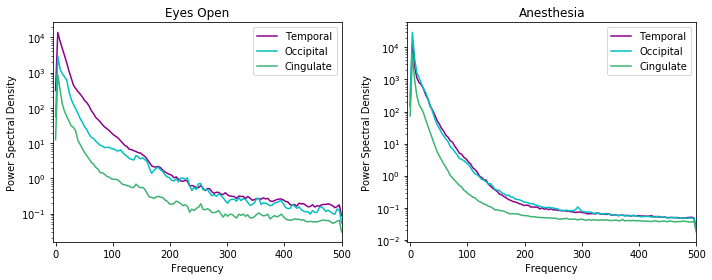

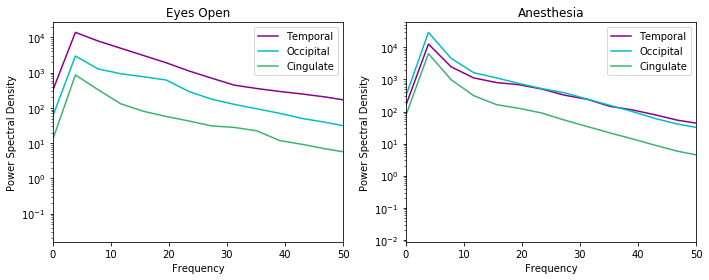

In [98]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title(states[0])
plot_PSD_region(open_temp_f_sp, open_temp_psd, open_occ_psd, open_cing_psd)

plt.subplot(1,2,2)
plt.title(states[1])
plot_PSD_region(anes_temp_f_sp, anes_temp_psd, anes_occ_psd, anes_cing_psd)
plt.tight_layout()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title(states[0])
plot_PSD_region(open_temp_f_sp, open_temp_psd, open_occ_psd, open_cing_psd)
plt.xlim([0,50])

plt.subplot(1,2,2)
plt.title(states[1])
plot_PSD_region(anes_temp_f_sp, anes_temp_psd, anes_occ_psd, anes_cing_psd)
plt.tight_layout()
plt.xlim([0,50])

plt.show()

Furthermore, we can see that about 4Hz contributes the most to both the awake and anesthetized signal. Each cortical area shows this same 4Hz contribution. This signifies that the underlying dominant frequency is from either the delta (0.5-8Hz) or theta (4-8Hz) band.

<a id='timefreq'></a>

## 3. Time-Frequency Analysis: STFT & Spectragram

In [132]:
def spectrogram_calibration(spg, t, f, freq_lims=[0,100], plot_db=False):
    
    plt.figure(figsize=(15,2))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect ='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

In [133]:
def plot_spectrogram(data, len_win, len_overlap):
    f_sp, t_sp, spg_sp = signal.spectrogram(data, fs, window='rect', \
    nperseg=int(fs*len_win), noverlap=int(fs*len_overlap), detrend=False)
    spg_sp = spg_sp*fs**2*len_win/2
    spectrogram_calibration(np.log10(spg_sp), t_sp, f_sp, plot_db=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


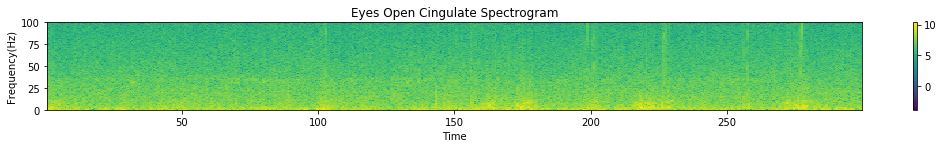

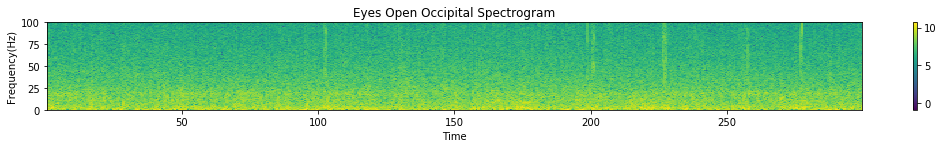

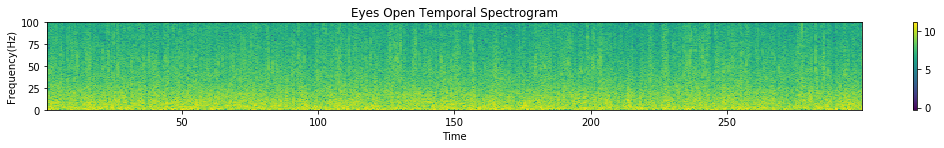

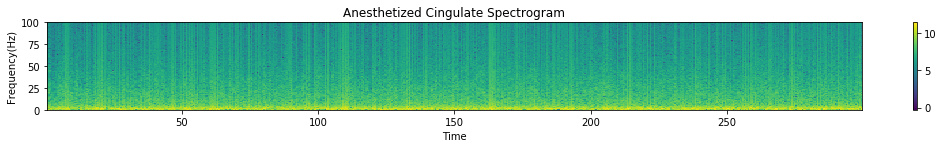

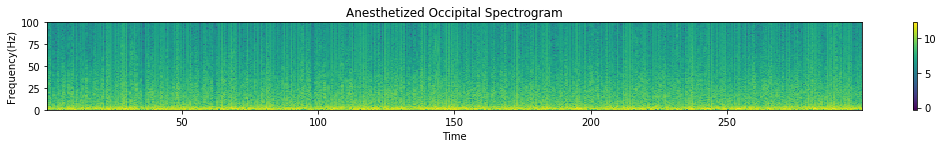

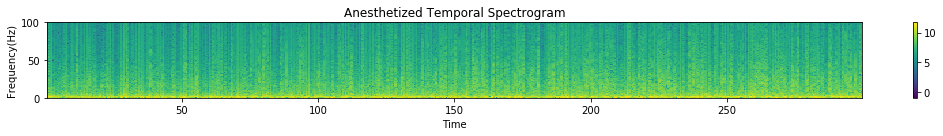

In [136]:
len_win = 1
len_overlap = 0.5
ylims = [0,100]

plot_spectrogram(awake_cingulate, len_win, len_overlap)
plt.title('Eyes Open Cingulate Spectrogram')
plt.ylim(ylims)

plot_spectrogram(awake_occipital, len_win, len_overlap)
plt.title('Eyes Open Occipital Spectrogram')
plt.ylim(ylims)

plot_spectrogram(awake_temporal, len_win, len_overlap)
plt.title('Eyes Open Temporal Spectrogram')
plt.ylim(ylims)

plot_spectrogram(anes_cingulate, len_win, len_overlap)
plt.title('Anesthetized Cingulate Spectrogram')
plt.ylim(ylims)

plot_spectrogram(anes_occipital, len_win, len_overlap)
plt.title('Anesthetized Occipital Spectrogram')
plt.ylim(ylims)

plot_spectrogram(anes_temporal, len_win, len_overlap)
plt.title('Anesthetized Temporal Spectrogram')
plt.ylim(ylims)

plt.tight_layout()
plt.show()

The spectrograms for the awake data is noticeably brighter than the spectrograms for the anesthesized data, aside from the very low frequencies (< 2.5Hz). This allows us to conclude that higher frequencies are more present during the awake state than the anesthesized state overall. In the Cingulate region, there are periodic lines of yellow that appears to be present beginning around 60 seconds and occuring seemingly periodically every 50 seconds. This indicates that every 50 seconds, all of the frequencies contribute to the signal. 

<a id='filter'></a>

## 4. Filtering Each Brainwave

We apply a bandpass filter for each of the brainwaves, filtering out the rest of the frequencies.

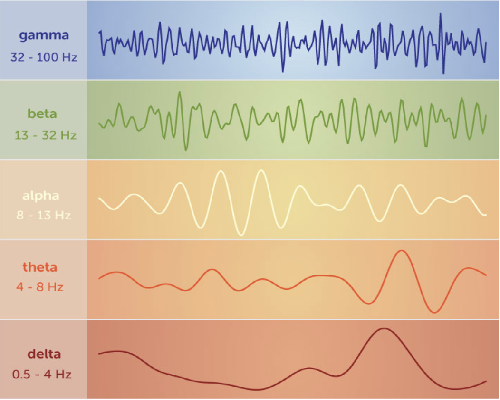

In [16]:
brainwaves = Image.open('Brainwaves.png').resize((500,400))
brainwaves

In [137]:
def plot_brainwave_decomp(awake, anes):
    plt.figure(figsize=(25,15))
    
    plt.subplot(6,2,1)
    plt.plot(t_vector, awake, color = 'cadetblue') #plot original signal
    plt.title("Awake Signal")
    plt.xlim(0,5)

    for i in range(0,10,2):
        FIR = signal.firwin(751, bandpass_values[int(i-0.5*i)], fs = fs, pass_zero = False)
        oscillation = np.convolve(awake, FIR, mode='same')
        plt.subplot(6,2,i+3)
        plt.plot(t_vector, oscillation, color = colors[int(i-0.5*i)])
        plt.xlabel("Time")
        plt.ylabel(brain_wave_names[int(i-0.5*i)])
        plt.ylim(-1500,1500)
        plt.xlim(0,5)

    plt.subplot(6,2,2)
    plt.plot(t_vector, anes, color = 'cadetblue') #plot original signal
    plt.title("Anesthesia Signal")
    plt.xlim(0,5)

    for i in range(0,10,2):
        FIR = signal.firwin(751, bandpass_values[int(i-0.5*i)], fs = fs, pass_zero = False)
        oscillation = np.convolve(anes, FIR, mode='same')
        plt.subplot(6,2,i+4)
        plt.plot(t_vector, oscillation, color = colors[int(i-0.5*i)])
        plt.xlabel("Time")
        plt.ylim(-1500,1500)
        plt.xlim(0,5)
    plt.tight_layout()

### Temporal Lobe: Awake vs. Anesthesia 

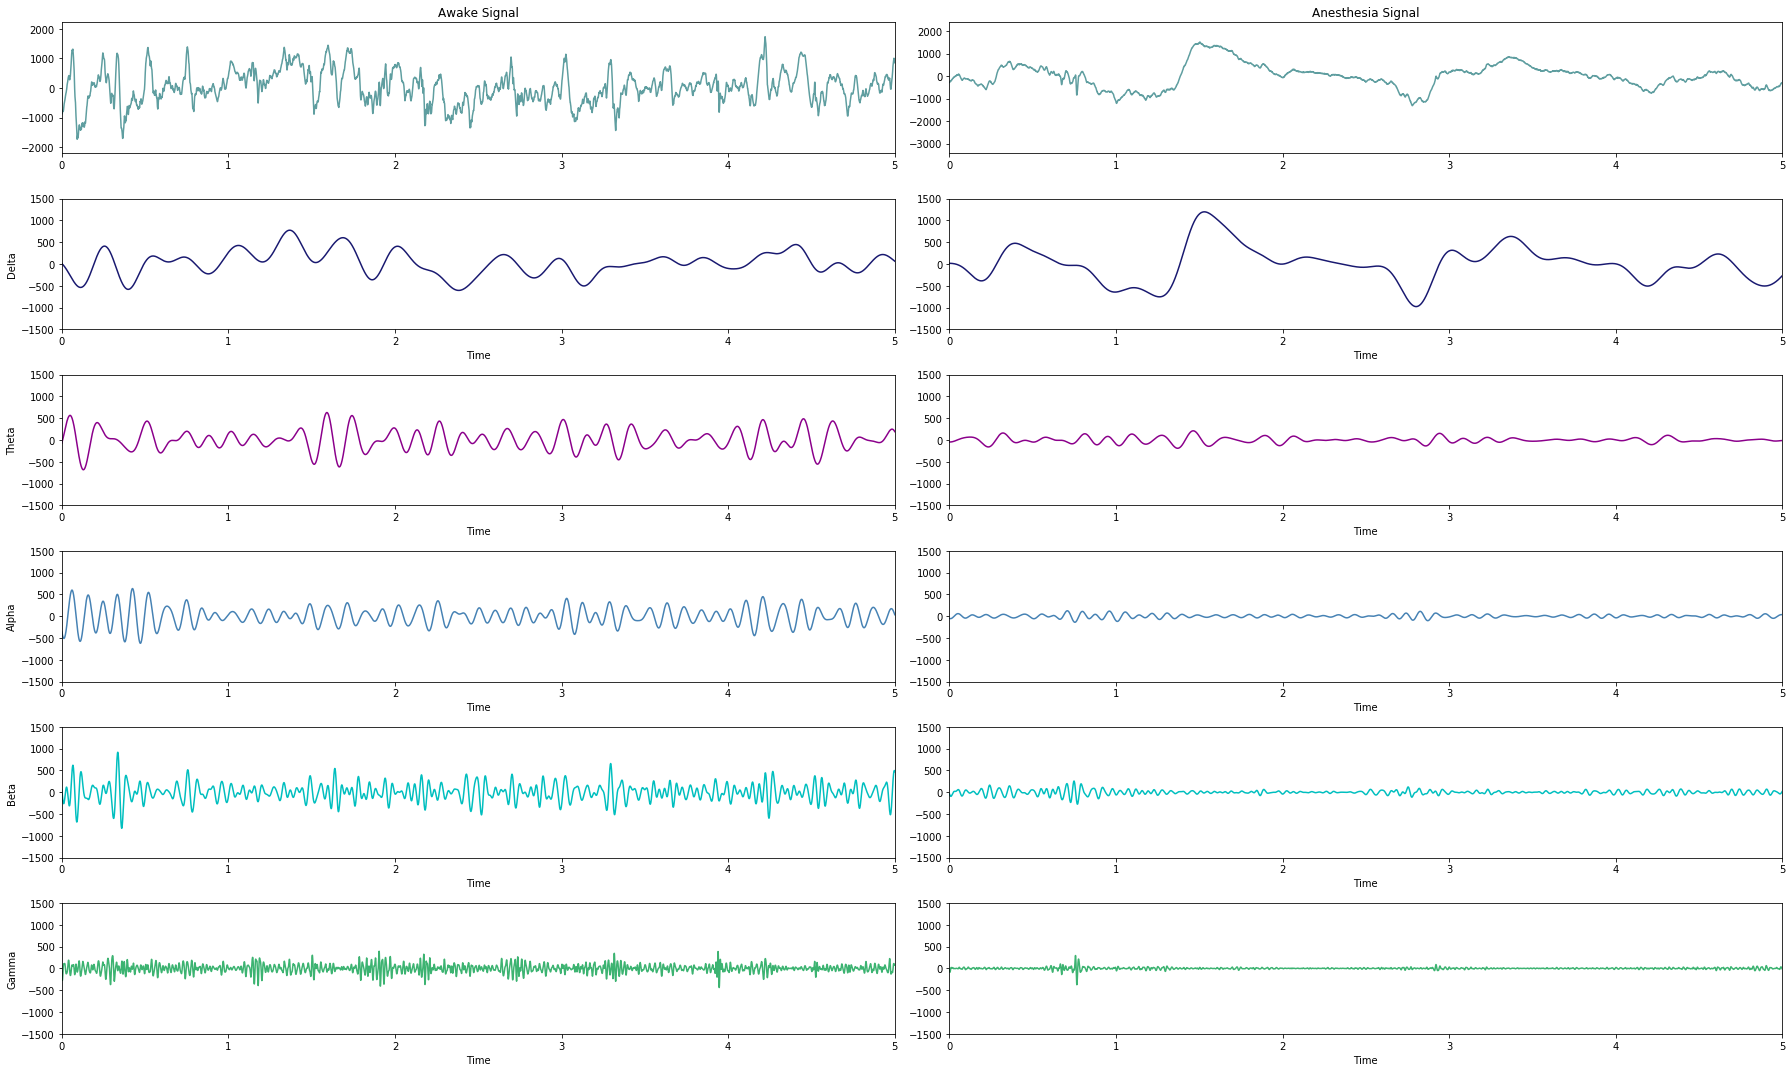

In [18]:
plot_brainwave_decomp(awake_temporal, anes_temporal)

### Occipital Lobe: Awake vs. Anesthesia

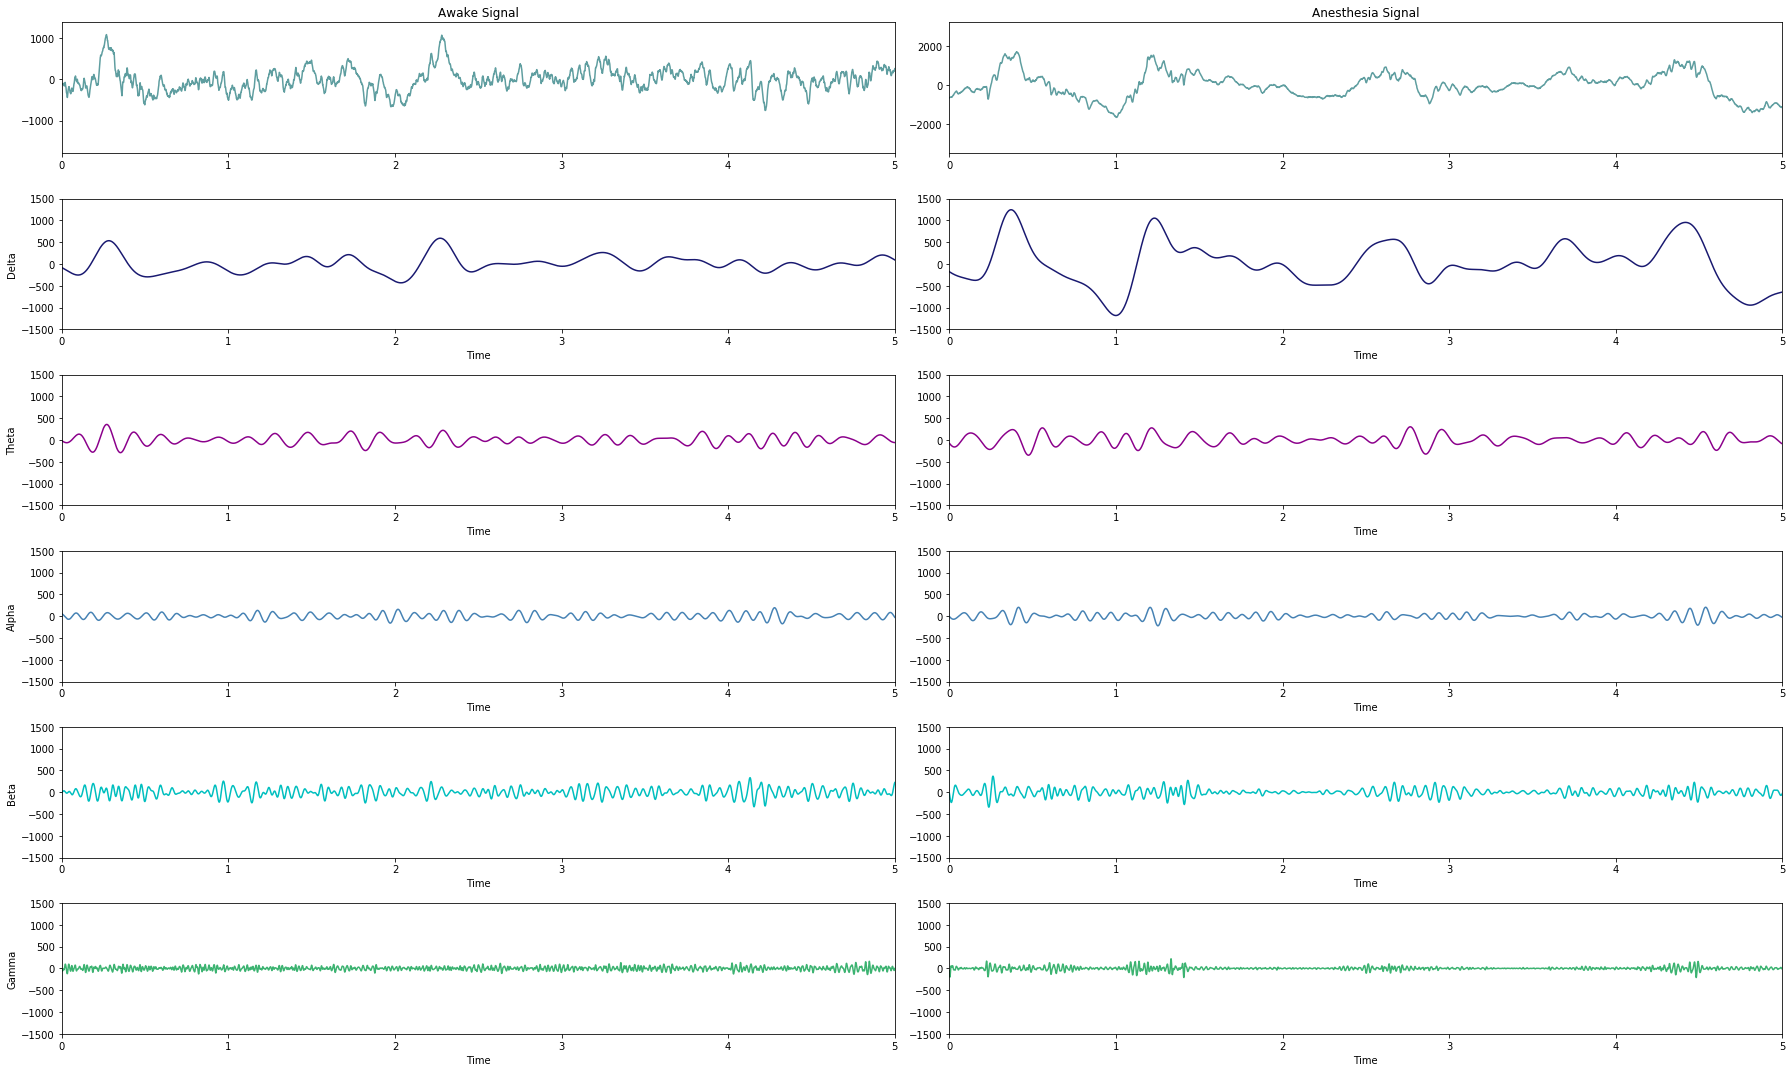

In [19]:
plot_brainwave_decomp(awake_occipital, anes_occipital)

### Cingulate Region: Awake vs. Anesthesia

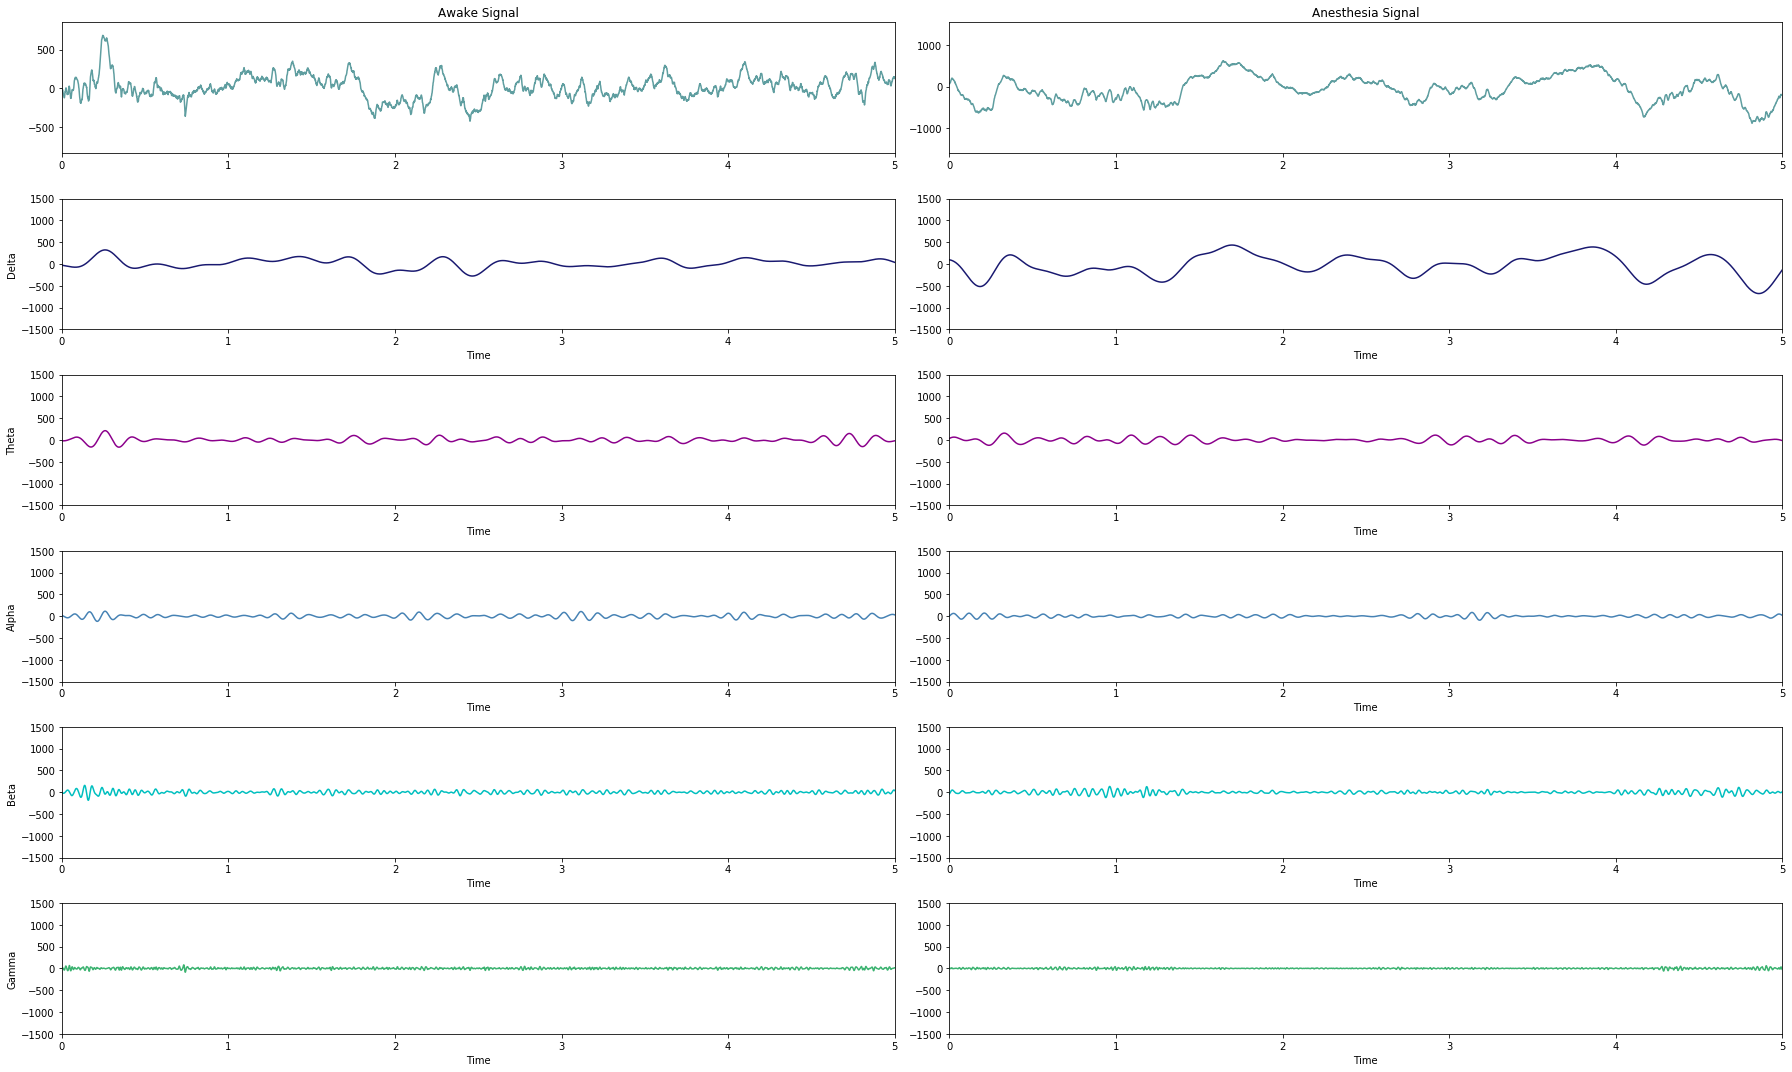

In [20]:
plot_brainwave_decomp(awake_cingulate, anes_cingulate)

<a id='instant'></a>

## 5. Instantaneous Power Signal for Theta Oscillations 

In this section, we compute the analytic signal (omitting the negative frequencies) and compute the instantaneous power of the theta frequency through time in order to gauge whether or not theta oscillations are regular and continuous for all states. 

In [21]:
#plots the instantaneous power signal for a particular oscillation
def plot_theta_osc_power(data, cutoff):
    num_rows = 2
    num_columns = 1
    for i in range(num_rows):
        plt.subplot(num_rows,num_columns, i+1)
        plt.ylabel("Voltage")
        plt.xlabel("Time")
        plt.title(states[i])
        plt.xlim(0,5)
        theta_power = compute_instant_power_phase(data[i], cutoff)[1]
        plt.plot(t_vector, theta_power, color = colors[i])
    plt.tight_layout()

In [22]:
def compute_instant_power_phase(data, cutoff):
    FIR_theta = signal.firwin(800, cutoff, fs=fs, pass_zero=False)
    theta_osc = np.convolve(data, FIR_theta,mode='same')
    x_a_theta = signal.hilbert(theta_osc)
    theta_phase = np.angle(x_a_theta)
    theta_power = np.abs(x_a_theta)**2
    return theta_phase, theta_power

In [23]:
#plots the instantaneous power signal for a particular oscillation
def plot_theta_osc_phase(data, cutoff):
    num_rows = 2
    num_columns = 1
    for i in range(num_rows):
        plt.subplot(num_rows,num_columns, i+1)
        plt.ylabel("Instantaneous Phase")
        plt.xlabel("Time")
        plt.title(states[i])
        plt.xlim(0,5)
        theta_phase = compute_instant_power_phase(data[i], cutoff)[0]
        plt.plot(t_vector, theta_phase, color = colors[i])
    plt.tight_layout()

### Theta Oscillation Power in Temporal Cortex

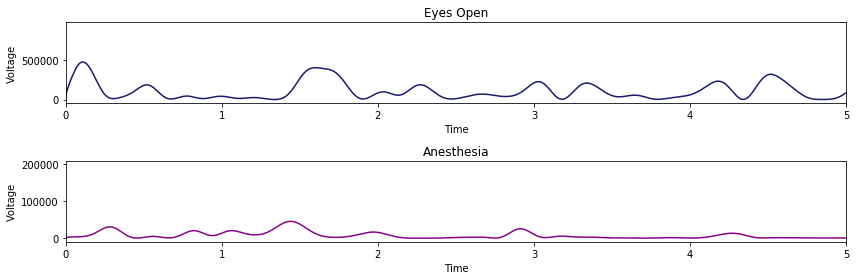

In [24]:
plt.figure(figsize=(12,4))
plot_theta_osc_power([awake_temporal,  anes_temporal], [4,8])

### Theta Oscillations in Occipital Cortex

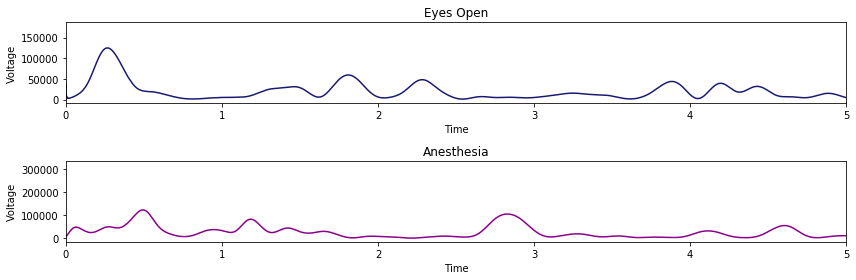

In [25]:
plt.figure(figsize=(12,4))
plot_theta_osc_power([awake_occipital, anes_occipital], [4,8])

### Theta Oscillations in the Cingulate

Look at the DFT of the theta oscillations to see how frequent the theta oscillations are.

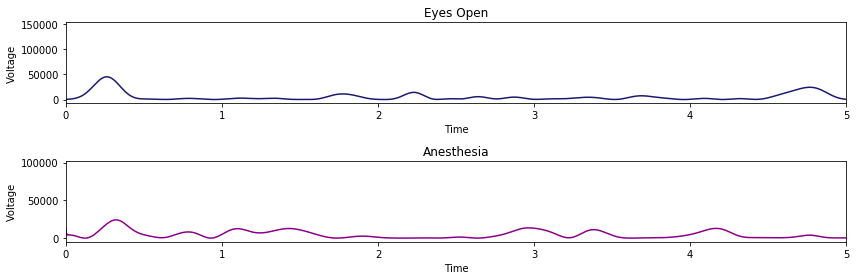

In [26]:
plt.figure(figsize=(12,4))
plot_theta_osc_power([awake_cingulate, anes_cingulate], [4,8])

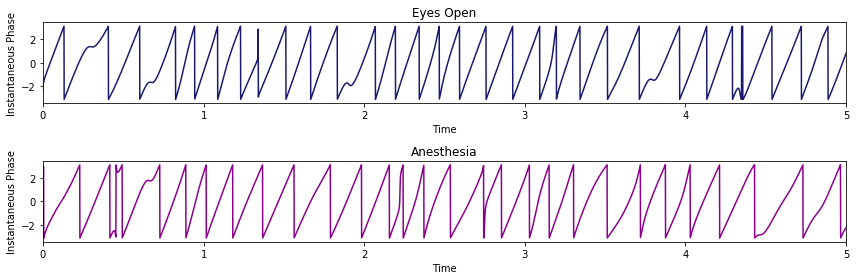

In [27]:
plt.figure(figsize=(12,4))
plot_theta_osc_phase([awake_temporal,  anes_temporal], [4,8])

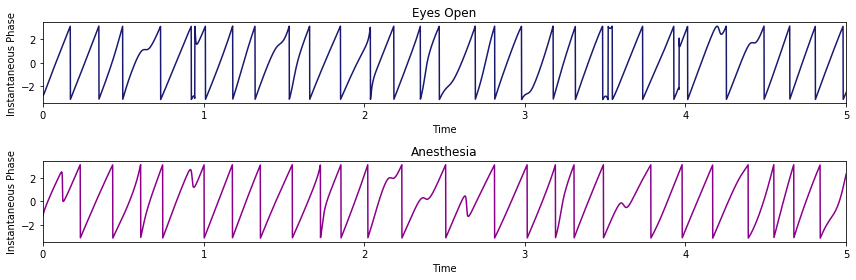

In [28]:
plt.figure(figsize=(12,4))
plot_theta_osc_phase([awake_cingulate, anes_cingulate], [4,8])

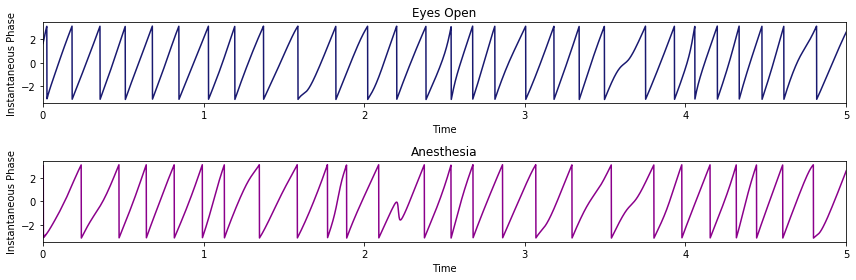

In [29]:
plt.figure(figsize=(12,4))
plot_theta_osc_phase([awake_occipital, anes_occipital], [4,8])

In [30]:
def compute_power_phase(x_a):
     
    return (np.abs(x_a)**2), np.angle(x_a)

#theta_power, theta_phase = compute_power_phase(x_a_theta)

<a id='coupling'></a>

## Theta Phase Coupling Between Regions

## Instantaneous Phase Synchrony
Many speculate that consciousness may arise from synchronization in the brain. We decided to look at ____ oscillation and see if there is a basis for consciousness 

In [31]:
def plt_phase_synchrony(temp,occ,cing,title):
    
    plt.figure(figsize=(20,10))
    plt.subplot(3,1,1)

    temp_phase = compute_instant_power_phase(temp, [13,32])[0]
    occ_phase = compute_instant_power_phase(occ, [13,32])[0]
    cing_phase = compute_instant_power_phase(cing, [13,32])[0]


    plt.plot(t_vector, temp_phase, color = colors[4], label='Temporal')
    plt.plot(t_vector, occ_phase, color = colors[1], label = 'Occipital')
    plt.plot(t_vector, cing_phase, color = colors[2], label = 'Cingulate')
    plt.title(title)
    plt.xlabel("Time")
    plt.xlim(0,1)
    plt.legend()

    plt.subplot(3,1,2)
    cing_temp_synchrony = 1-np.sin(np.abs(temp_phase-cing_phase)/2)
    occ_temp_synchrony = 1-np.sin(np.abs(temp_phase-occ_phase)/2)
    occ_cing_synchrony = 1-np.sin(np.abs(occ_phase-cing_phase)/2)

    plt.plot(t_vector, cing_temp_synchrony, color = colors[4], label = 'Cingulate Temporal')
    plt.plot(t_vector, occ_temp_synchrony, color = colors[1], label = 'Occipital Temporal')
    plt.plot(t_vector, occ_cing_synchrony, color = colors[2], label = 'Occipital Cingulate')

    plt.title("Instantaneous Phase Synchrony")
    plt.xlabel("Time")
    plt.ylabel("Phase Synchrony")
    plt.xlim(0, 1)
    plt.legend()

    plt.subplot(3,1,3)
    average_sync = (cing_temp_synchrony + occ_temp_synchrony+occ_cing_synchrony)/3
    plt.plot(t_vector, average_sync, color = 'steelblue', label = 'Occipital Cingulate')
    plt.title("Averaged Phase Synchrony Across All Regions")
    plt.ylabel("Phase Synchronization")
    plt.xlabel("Time")
    plt.xlim(0,1)

    plt.tight_layout()
    return average_sync

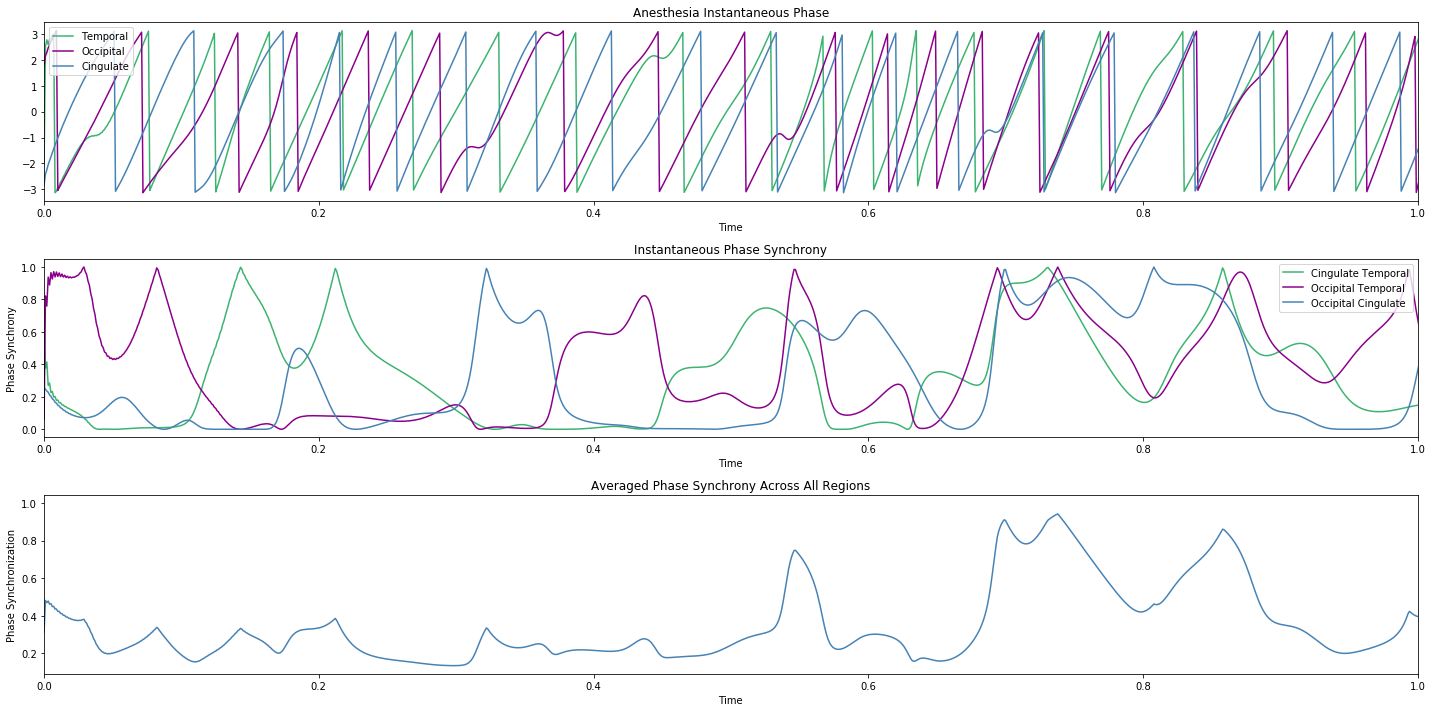

In [32]:
average_anes_sync = plt_phase_synchrony(anes_temporal,anes_occipital,anes_cingulate, "Anesthesia Instantaneous Phase")

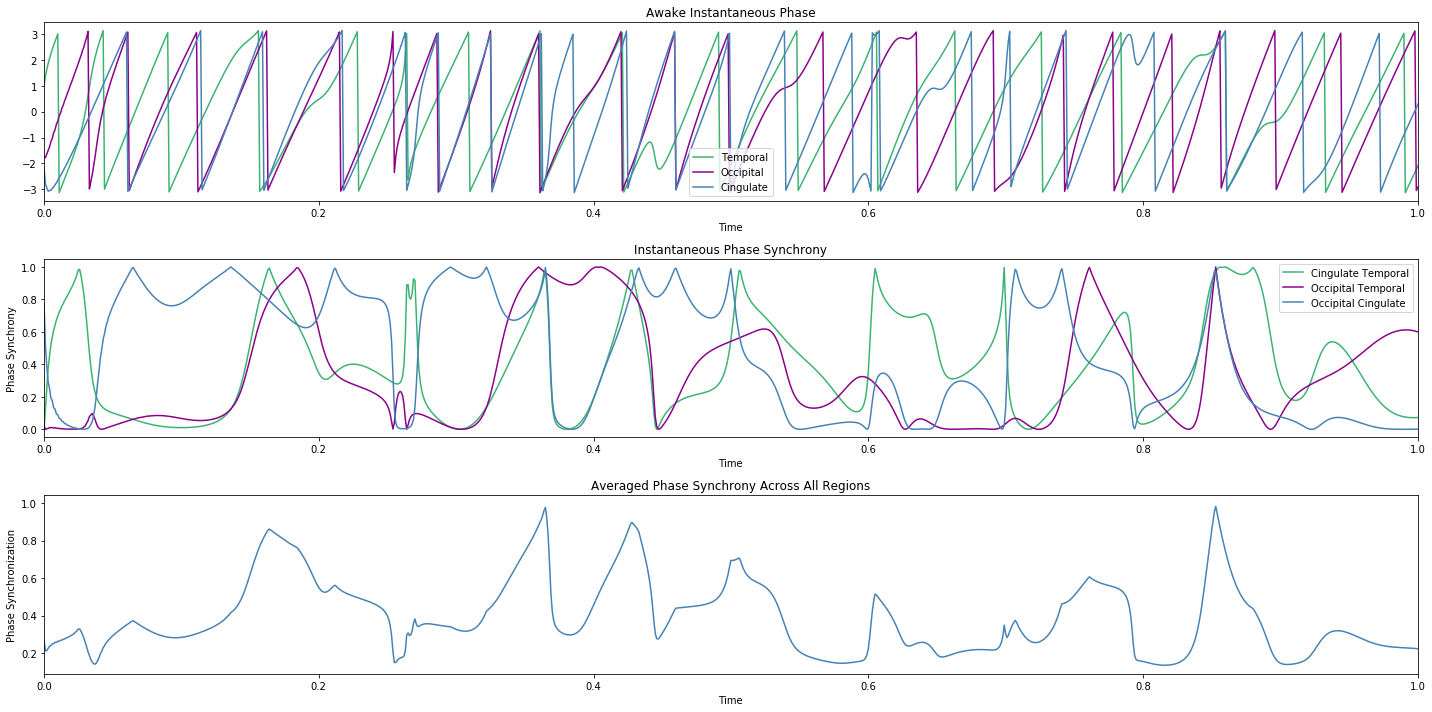

In [33]:
average_awake_sync = plt_phase_synchrony(awake_temporal, awake_occipital, awake_cingulate, "Awake Instantaneous Phase")

In [34]:
average_awake_synchrony = np.mean(average_awake_sync)
average_anes_synchrony = np.mean(average_anes_sync)

print('Average Awake Phase Synchronization: {}'.format(average_awake_synchrony))
print('Average Anesthesia Phase Synchronization: {}'.format(average_anes_synchrony))

Average Awake Phase Synchronization: 0.3861623201365843
Average Anesthesia Phase Synchronization: 0.43308063561133975


<a id='results'></a>

## Data Results


<a id='conclude'></a>

## Conclusion & Discussions

<a id='considerations'></a>
## Considerations & Limitations

<a id='refer'></a>
## References & Contributions